# Social Network Analysis: Mutual Friendships Only

This notebook analyzes the soc-Pokec dataset using **only mutual (reciprocal) friendships**.

## Graph Type
- **Mutual Graph**: Only edges where BOTH directions exist in the original directed graph
- This represents true bidirectional friendships (A follows B AND B follows A)
- More conservative but more meaningful for "friendship" analysis

## Step 1: Setup and Data Loading

In [1]:
import os
import networkx as nx
import numpy as np
import pandas as pd
import psutil
import time
import random
from pathlib import Path
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
try:
    plt.style.use('seaborn-v0_8-whitegrid')
except OSError:
    try:
        plt.style.use('seaborn-whitegrid')
    except OSError:
        plt.style.use('ggplot')

sns.set_palette('husl')

DATA_DIR = Path('data')
OUTPUTS_DIR = Path('outputs')
OUTPUTS_DIR.mkdir(exist_ok=True)

def get_memory_usage():
    """Return current memory usage in GB."""
    process = psutil.Process()
    return process.memory_info().rss / (1024 ** 3)

print(f"Initial memory usage: {get_memory_usage():.2f} GB")

Initial memory usage: 0.23 GB


In [2]:
# Load directed graph
print("Loading directed edge list...")
start_time = time.time()

edges_file = DATA_DIR / 'soc-pokec-relationships.txt'
G_directed = nx.read_edgelist(str(edges_file), create_using=nx.DiGraph(), nodetype=int)

load_time = time.time() - start_time
print(f"Loaded in {load_time:.2f} seconds")
print(f"Directed Graph - Nodes: {G_directed.number_of_nodes():,}, Edges: {G_directed.number_of_edges():,}")
print(f"Memory usage: {get_memory_usage():.2f} GB")

Loading directed edge list...
Loaded in 64.18 seconds
Directed Graph - Nodes: 1,632,803, Edges: 30,622,564
Memory usage: 6.76 GB


In [3]:
# Create MUTUAL (reciprocal) graph - only edges where both directions exist
print("Creating mutual (reciprocal) graph...")
start_time = time.time()

def create_mutual_graph(G_directed):
    """
    Create an undirected graph containing only mutual (reciprocal) edges.
    An edge (u, v) is included only if both (u, v) and (v, u) exist in the directed graph.
    """
    G_mutual = nx.Graph()
    G_mutual.add_nodes_from(G_directed.nodes())
    
    # Find reciprocal edges
    total_edges = G_directed.number_of_edges()
    for idx, (u, v) in enumerate(G_directed.edges()):
        if u < v and G_directed.has_edge(v, u):
            G_mutual.add_edge(u, v)
        if (idx + 1) % 5_000_000 == 0:
            print(f"  Processed {idx+1:,}/{total_edges:,} directed edges...")
    
    return G_mutual

G_mutual = create_mutual_graph(G_directed)
mutual_creation_time = time.time() - start_time

print(f"Mutual Graph - Nodes: {G_mutual.number_of_nodes():,}, Edges: {G_mutual.number_of_edges():,}")
print(f"Created in {mutual_creation_time:.2f} seconds")

# Compute reciprocity
reciprocity = nx.reciprocity(G_directed)
print(f"\nNetwork Reciprocity: {reciprocity:.4f} ({reciprocity*100:.2f}%)")
print(f"  - {reciprocity*100:.1f}% of directed edges are reciprocated")

print(f"\nMemory usage: {get_memory_usage():.2f} GB")

Creating mutual (reciprocal) graph...
  Processed 5,000,000/30,622,564 directed edges...
  Processed 10,000,000/30,622,564 directed edges...
  Processed 15,000,000/30,622,564 directed edges...
  Processed 20,000,000/30,622,564 directed edges...
  Processed 25,000,000/30,622,564 directed edges...
  Processed 30,000,000/30,622,564 directed edges...
Mutual Graph - Nodes: 1,632,803, Edges: 8,320,600
Created in 26.08 seconds

Network Reciprocity: 0.5434 (54.34%)
  - 54.3% of directed edges are reciprocated

Memory usage: 11.64 GB


In [4]:
# Free memory - remove directed graph
print("Freeing memory by removing directed graph...")
del G_directed
import gc
gc.collect()
print(f"Memory usage after cleanup: {get_memory_usage():.2f} GB")

Freeing memory by removing directed graph...
Memory usage after cleanup: 9.58 GB


## Step 2: Connected Component Analysis

In [5]:
# Get the largest connected component
print("Analyzing connected components...")
start_time = time.time()

components = list(nx.connected_components(G_mutual))
num_components = len(components)
largest_cc = max(components, key=len)

print(f"Number of connected components: {num_components:,}")
print(f"Largest component: {len(largest_cc):,} nodes ({100*len(largest_cc)/G_mutual.number_of_nodes():.2f}%)")

# Create subgraph of largest component
G = G_mutual.subgraph(largest_cc).copy()

# Free memory
del G_mutual, components
gc.collect()

print(f"\nWorking graph (LCC) - Nodes: {G.number_of_nodes():,}, Edges: {G.number_of_edges():,}")
print(f"Component analysis completed in {time.time() - start_time:.2f} seconds")
print(f"Memory usage: {get_memory_usage():.2f} GB")

Analyzing connected components...
Number of connected components: 426,901
Largest component: 1,198,274 nodes (73.39%)

Working graph (LCC) - Nodes: 1,198,274, Edges: 8,312,834
Component analysis completed in 41.40 seconds
Memory usage: 8.61 GB


## Step 3: Degrees of Separation Analysis

In [6]:
# Sample and compute shortest paths
print("="*60)
print("DEGREES OF SEPARATION ANALYSIS - MUTUAL GRAPH")
print("="*60)

NUM_SAMPLES = 10000
random.seed(42)

nodes_list = list(G.nodes())
path_lengths = []
failed_paths = 0
start_time = time.time()

sample_pairs = [(random.choice(nodes_list), random.choice(nodes_list)) for _ in range(NUM_SAMPLES)]

for i, (src, tgt) in enumerate(sample_pairs):
    if src == tgt:
        continue
    try:
        length = nx.shortest_path_length(G, src, tgt)
        path_lengths.append(length)
    except nx.NetworkXNoPath:
        failed_paths += 1
    
    if (i + 1) % 2500 == 0:
        print(f"Progress: {i+1}/{NUM_SAMPLES}")

compute_time = time.time() - start_time
print(f"\nCompleted in {compute_time:.2f}s")
print(f"Paths found: {len(path_lengths):,} | Failed: {failed_paths}")

DEGREES OF SEPARATION ANALYSIS - MUTUAL GRAPH
Progress: 2500/10000
Progress: 5000/10000
Progress: 7500/10000
Progress: 10000/10000

Completed in 4.05s
Paths found: 10,000 | Failed: 0


In [7]:
# Calculate statistics
avg_degree_sep = np.mean(path_lengths)
median_degree_sep = np.median(path_lengths)
std_degree_sep = np.std(path_lengths)
min_degree_sep = min(path_lengths)
max_degree_sep = max(path_lengths)

print("\n" + "="*60)
print("DEGREES OF SEPARATION RESULTS (MUTUAL GRAPH)")
print("="*60)
print(f"Average degrees of separation: {avg_degree_sep:.2f}")
print(f"Median degrees of separation: {median_degree_sep:.2f}")
print(f"Standard deviation: {std_degree_sep:.2f}")
print(f"Min path length: {min_degree_sep}")
print(f"Max path length: {max_degree_sep}")

print(f"\n{'Six Degrees of Separation':}")
if avg_degree_sep <= 6:
    print(f"   ✅ CONFIRMED! Average is {avg_degree_sep:.2f} degrees")
else:
    print(f"   ❌ NOT confirmed. Average is {avg_degree_sep:.2f} degrees")

# Distribution
print(f"\nPath Length Distribution:")
distribution = Counter(path_lengths)
for length in sorted(distribution.keys()):
    count = distribution[length]
    pct = 100 * count / len(path_lengths)
    bar = '█' * int(pct / 2)
    print(f"  {length}: {count:,} ({pct:.1f}%) {bar}")


DEGREES OF SEPARATION RESULTS (MUTUAL GRAPH)
Average degrees of separation: 5.68
Median degrees of separation: 6.00
Standard deviation: 1.06
Min path length: 2
Max path length: 12

Six Degrees of Separation
   ✅ CONFIRMED! Average is 5.68 degrees

Path Length Distribution:
  2: 5 (0.1%) 
  3: 110 (1.1%) 
  4: 989 (9.9%) ████
  5: 3,374 (33.7%) ████████████████
  6: 3,584 (35.8%) █████████████████
  7: 1,485 (14.8%) ███████
  8: 364 (3.6%) █
  9: 77 (0.8%) 
  10: 7 (0.1%) 
  11: 4 (0.0%) 
  12: 1 (0.0%) 


## Step 4: Network Metrics

In [8]:
# Compute network metrics
print("="*60)
print("NETWORK METRICS (MUTUAL GRAPH)")
print("="*60)

degrees = [d for n, d in G.degree()]
avg_degree = np.mean(degrees)
density = nx.density(G)

print(f"\nBasic Metrics:")
print(f"  Nodes: {G.number_of_nodes():,}")
print(f"  Edges: {G.number_of_edges():,}")
print(f"  Average degree: {avg_degree:.2f}")
print(f"  Network density: {density:.6f}")

print(f"\nDegree Statistics:")
print(f"  Min degree: {min(degrees)}")
print(f"  Max degree: {max(degrees)}")
print(f"  Median degree: {np.median(degrees):.0f}")
print(f"  Std deviation: {np.std(degrees):.2f}")

NETWORK METRICS (MUTUAL GRAPH)

Basic Metrics:
  Nodes: 1,198,274
  Edges: 8,312,834
  Average degree: 13.87
  Network density: 0.000012

Degree Statistics:
  Min degree: 1
  Max degree: 7266
  Median degree: 7
  Std deviation: 21.20


In [9]:
# Clustering coefficient (sampled)
print("\nComputing clustering coefficient (sampled)...")
sample_nodes = random.sample(list(G.nodes()), min(10000, G.number_of_nodes()))
clustering_coeffs = nx.clustering(G, nodes=sample_nodes)
avg_clustering = np.mean(list(clustering_coeffs.values()))

print(f"  Average clustering coefficient: {avg_clustering:.4f}")


Computing clustering coefficient (sampled)...
  Average clustering coefficient: 0.1036


## Step 5: Community Detection

In [10]:
import community as community_louvain

# BFS sampling for community detection
COMMUNITY_SAMPLE_SIZE = 50000

def bfs_sample(G, start_node, max_nodes):
    """Sample a connected subgraph using BFS from a start node."""
    visited = set()
    queue = [start_node]
    visited.add(start_node)
    
    while queue and len(visited) < max_nodes:
        node = queue.pop(0)
        for neighbor in G.neighbors(node):
            if neighbor not in visited:
                visited.add(neighbor)
                queue.append(neighbor)
                if len(visited) >= max_nodes:
                    break
    return visited

print(f"Creating connected sample using BFS...")

# Start from a high-degree node
degrees_dict = dict(G.degree())
start_node = max(degrees_dict, key=degrees_dict.get)
print(f"Starting BFS from node {start_node} (degree: {degrees_dict[start_node]})")

sample_nodes_community = bfs_sample(G, start_node, COMMUNITY_SAMPLE_SIZE)
G_sample = G.subgraph(sample_nodes_community).copy()

print(f"Sample graph - Nodes: {G_sample.number_of_nodes():,}, Edges: {G_sample.number_of_edges():,}")

Creating connected sample using BFS...
Starting BFS from node 5867 (degree: 7266)
Sample graph - Nodes: 50,000, Edges: 223,265


In [11]:
# Run Louvain community detection
print("Running Louvain community detection...")
start_time = time.time()

partition = community_louvain.best_partition(G_sample, random_state=42)
modularity = community_louvain.modularity(partition, G_sample)

community_time = time.time() - start_time
print(f"Completed in {community_time:.2f} seconds")

# Analyze communities
community_sizes = Counter(partition.values())
num_communities = len(community_sizes)

print(f"\n{'='*60}")
print("COMMUNITY DETECTION RESULTS (MUTUAL GRAPH)")
print(f"{'='*60}")
print(f"Number of communities: {num_communities}")
print(f"Modularity score: {modularity:.4f}")
print(f"\nTop 10 largest communities:")
for i, (comm_id, size) in enumerate(community_sizes.most_common(10)):
    pct = 100 * size / G_sample.number_of_nodes()
    print(f"  Community {comm_id}: {size:,} nodes ({pct:.1f}%)")

sizes = list(community_sizes.values())
print(f"\nCommunity size statistics:")
print(f"  Average: {np.mean(sizes):.1f} nodes")
print(f"  Median: {np.median(sizes):.1f} nodes")
print(f"  Largest: {max(sizes):,} nodes")
print(f"  Smallest: {min(sizes)} nodes")

Running Louvain community detection...
Completed in 6.43 seconds

COMMUNITY DETECTION RESULTS (MUTUAL GRAPH)
Number of communities: 37
Modularity score: 0.7855

Top 10 largest communities:
  Community 31: 4,429 nodes (8.9%)
  Community 1: 3,309 nodes (6.6%)
  Community 3: 2,708 nodes (5.4%)
  Community 2: 2,652 nodes (5.3%)
  Community 25: 2,218 nodes (4.4%)
  Community 16: 2,052 nodes (4.1%)
  Community 26: 2,031 nodes (4.1%)
  Community 19: 1,926 nodes (3.9%)
  Community 20: 1,822 nodes (3.6%)
  Community 9: 1,691 nodes (3.4%)

Community size statistics:
  Average: 1351.4 nodes
  Median: 1294.0 nodes
  Largest: 4,429 nodes
  Smallest: 47 nodes


## Step 6: Centrality Analysis

In [12]:
# Centrality analysis on sample
print("="*60)
print("CENTRALITY ANALYSIS (MUTUAL GRAPH)")
print("="*60)

CENTRALITY_SAMPLE = 10000
if G_sample.number_of_nodes() > CENTRALITY_SAMPLE:
    centrality_nodes = bfs_sample(G_sample, start_node, CENTRALITY_SAMPLE)
    G_centrality = G_sample.subgraph(centrality_nodes).copy()
else:
    G_centrality = G_sample

print(f"Computing centrality on {G_centrality.number_of_nodes():,} nodes...")

# Degree centrality
print("\nDegree Centrality:")
degree_centrality = nx.degree_centrality(G_centrality)
top_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print("  Top 10 nodes:")
for node, cent in top_degree:
    print(f"    Node {node}: {cent:.4f} (degree: {G_centrality.degree(node)})")

CENTRALITY ANALYSIS (MUTUAL GRAPH)
Computing centrality on 10,000 nodes...

Degree Centrality:
  Top 10 nodes:
    Node 5867: 0.7267 (degree: 7266)
    Node 1891: 0.4476 (degree: 4476)
    Node 6228: 0.2262 (degree: 2262)
    Node 25994: 0.1133 (degree: 1133)
    Node 1830: 0.0958 (degree: 958)
    Node 5935: 0.0341 (degree: 341)
    Node 131288: 0.0136 (degree: 136)
    Node 2921: 0.0098 (degree: 98)
    Node 3624: 0.0094 (degree: 94)
    Node 157: 0.0092 (degree: 92)


In [13]:
# Betweenness centrality (sampled)
print("\nBetweenness Centrality (sampled):")
start_time = time.time()
betweenness = nx.betweenness_centrality(G_centrality, k=min(500, G_centrality.number_of_nodes()))
top_betweenness = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)[:10]
print(f"  Computed in {time.time() - start_time:.2f}s")
print("  Top 10 nodes:")
for node, cent in top_betweenness:
    print(f"    Node {node}: {cent:.6f}")


Betweenness Centrality (sampled):
  Computed in 18.29s
  Top 10 nodes:
    Node 5867: 0.750941
    Node 1891: 0.198608
    Node 6228: 0.044777
    Node 2921: 0.019293
    Node 1830: 0.013469
    Node 3624: 0.013251
    Node 131288: 0.012832
    Node 854: 0.011579
    Node 25994: 0.011327
    Node 133675: 0.010994


In [14]:
# PageRank
print("\nPageRank:")
start_time = time.time()
pagerank = nx.pagerank(G_sample, alpha=0.85, max_iter=100)
top_pagerank = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)[:10]
print(f"  Computed in {time.time() - start_time:.2f}s")
print("  Top 10 nodes:")
for node, score in top_pagerank:
    print(f"    Node {node}: {score:.6f}")


PageRank:
  Computed in 0.21s
  Top 10 nodes:
    Node 5867: 0.017573
    Node 1891: 0.009773
    Node 6228: 0.006665
    Node 25994: 0.002843
    Node 5935: 0.001995
    Node 1830: 0.001984
    Node 188861: 0.001274
    Node 25855: 0.000650
    Node 69937: 0.000606
    Node 57648: 0.000447


## Step 7: Link Prediction

In [15]:
# Create sample for link prediction
LINK_PRED_SAMPLE = 5000

print(f"Creating sample for link prediction...")
sample_nodes_lp = bfs_sample(G, start_node, LINK_PRED_SAMPLE)
G_lp = G.subgraph(sample_nodes_lp).copy()

print(f"Link prediction sample - Nodes: {G_lp.number_of_nodes():,}, Edges: {G_lp.number_of_edges():,}")

# Generate non-edges
print("Generating candidate pairs...")
existing_edges = set(G_lp.edges())
lp_nodes = list(G_lp.nodes())

non_edges = []
high_degree_nodes = [n for n in lp_nodes if G_lp.degree(n) >= 3]

attempts = 0
while len(non_edges) < 1000 and attempts < 50000:
    if len(high_degree_nodes) >= 2:
        u, v = random.sample(high_degree_nodes, 2)
    else:
        u, v = random.sample(lp_nodes, 2)
    
    if (u, v) not in existing_edges and (v, u) not in existing_edges and u != v:
        common = len(set(G_lp.neighbors(u)) & set(G_lp.neighbors(v)))
        if common > 0 or attempts > 25000:
            non_edges.append((u, v))
    attempts += 1

print(f"Generated {len(non_edges)} non-edge pairs")

Creating sample for link prediction...
Link prediction sample - Nodes: 5,000, Edges: 9,293
Generating candidate pairs...
Generated 1000 non-edge pairs


In [16]:
# Link prediction methods
print("\nJaccard Coefficient - Top 10 predictions:")
jaccard_preds = sorted(nx.jaccard_coefficient(G_lp, non_edges), key=lambda x: x[2], reverse=True)[:10]
for u, v, score in jaccard_preds:
    print(f"  ({u}, {v}): {score:.4f}")

print("\nAdamic-Adar Index - Top 10 predictions:")
aa_preds = sorted(nx.adamic_adar_index(G_lp, non_edges), key=lambda x: x[2], reverse=True)[:10]
for u, v, score in aa_preds:
    print(f"  ({u}, {v}): {score:.4f}")


Jaccard Coefficient - Top 10 predictions:
  (63454, 156381): 1.0000
  (97498, 54704): 1.0000
  (66544, 147402): 1.0000
  (70241, 79527): 1.0000
  (99189, 98672): 0.7500
  (129190, 70825): 0.7500
  (98673, 102008): 0.7500
  (99311, 138650): 0.7500
  (105500, 100837): 0.7500
  (89342, 32683): 0.7500

Adamic-Adar Index - Top 10 predictions:
  (8268, 66024): 0.8870
  (99189, 98672): 0.4058
  (98422, 94424): 0.4058
  (96053, 148231): 0.4058
  (129190, 70825): 0.4058
  (98673, 102008): 0.4058
  (99311, 138650): 0.4058
  (141909, 98660): 0.4058
  (97296, 79534): 0.4058
  (97476, 97297): 0.4058


## Step 8: Visualizations

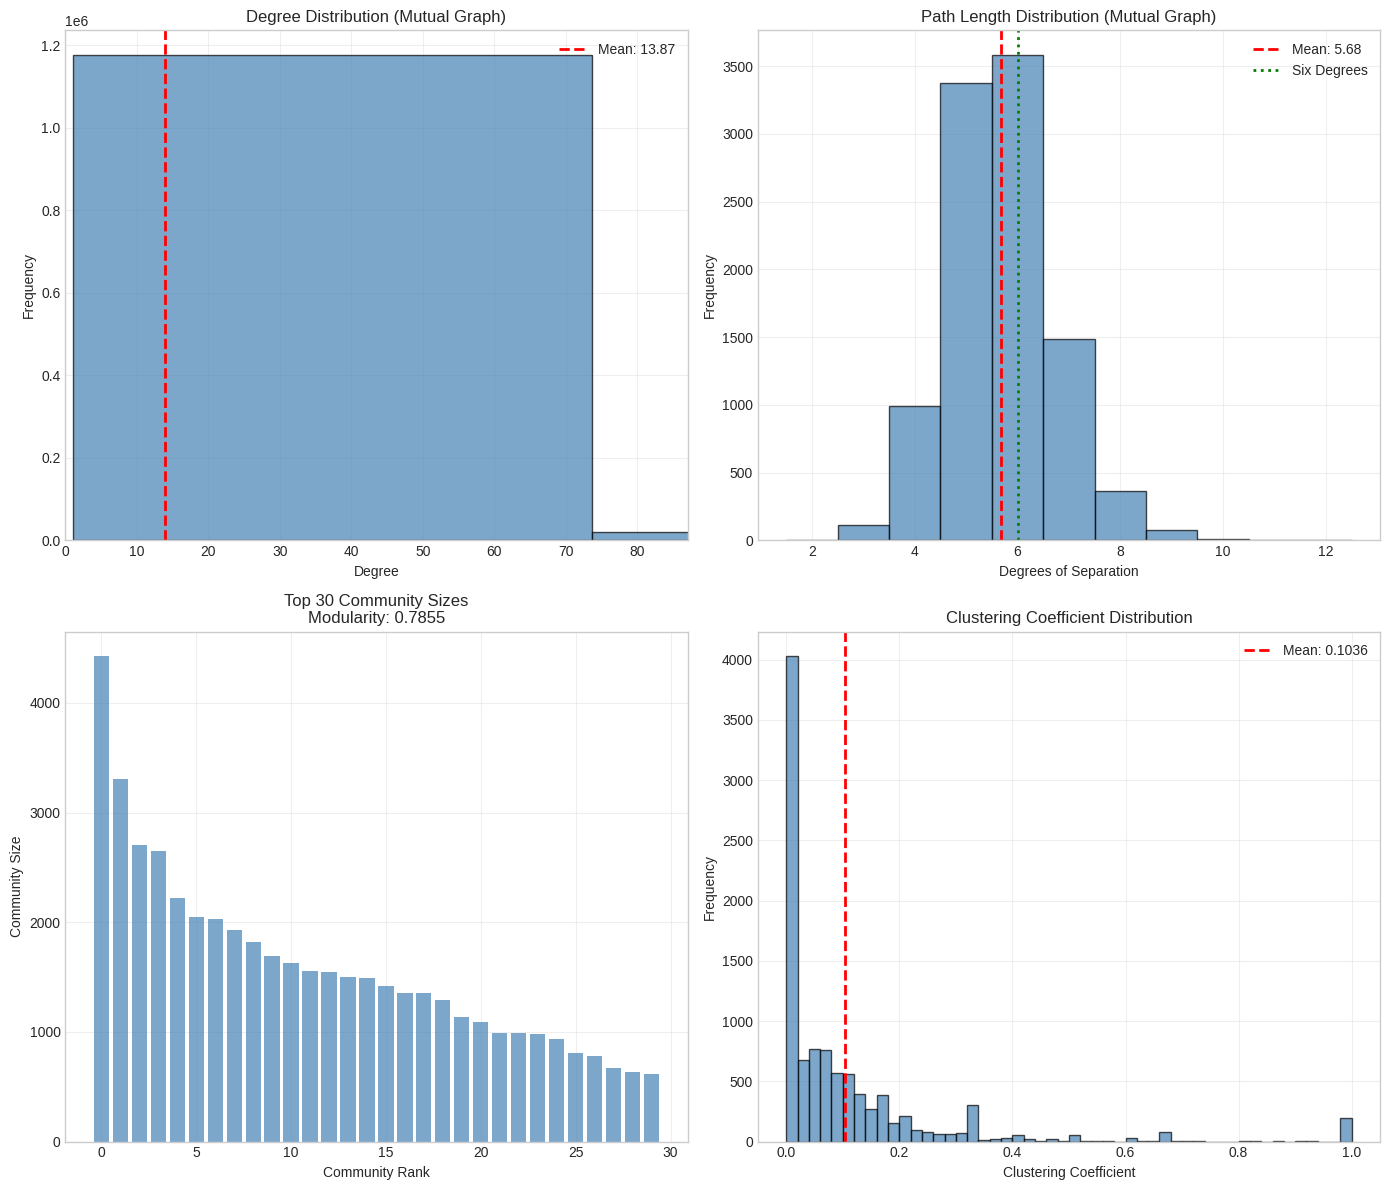

Figure saved to outputs/mutual_friendships_analysis.png


In [17]:
# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 1. Degree distribution
ax1 = axes[0, 0]
ax1.hist(degrees, bins=100, alpha=0.7, color='steelblue', edgecolor='black')
ax1.axvline(avg_degree, color='red', linestyle='--', linewidth=2, label=f'Mean: {avg_degree:.2f}')
ax1.set_xlabel('Degree')
ax1.set_ylabel('Frequency')
ax1.set_title('Degree Distribution (Mutual Graph)')
ax1.set_xlim(0, np.percentile(degrees, 99))
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Path length distribution
ax2 = axes[0, 1]
bins = range(min(path_lengths), max(path_lengths) + 2)
ax2.hist(path_lengths, bins=bins, alpha=0.7, color='steelblue', edgecolor='black', align='left')
ax2.axvline(avg_degree_sep, color='red', linestyle='--', linewidth=2, label=f'Mean: {avg_degree_sep:.2f}')
ax2.axvline(6, color='green', linestyle=':', linewidth=2, label='Six Degrees')
ax2.set_xlabel('Degrees of Separation')
ax2.set_ylabel('Frequency')
ax2.set_title('Path Length Distribution (Mutual Graph)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Community size distribution
ax3 = axes[1, 0]
sizes_sorted = sorted(sizes, reverse=True)
ax3.bar(range(min(30, len(sizes_sorted))), sizes_sorted[:30], color='steelblue', alpha=0.7)
ax3.set_xlabel('Community Rank')
ax3.set_ylabel('Community Size')
ax3.set_title(f'Top 30 Community Sizes\nModularity: {modularity:.4f}')
ax3.grid(True, alpha=0.3)

# 4. Clustering coefficient distribution
ax4 = axes[1, 1]
clustering_values = list(clustering_coeffs.values())
ax4.hist(clustering_values, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
ax4.axvline(avg_clustering, color='red', linestyle='--', linewidth=2, label=f'Mean: {avg_clustering:.4f}')
ax4.set_xlabel('Clustering Coefficient')
ax4.set_ylabel('Frequency')
ax4.set_title('Clustering Coefficient Distribution')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUTS_DIR / 'mutual_friendships_analysis.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Figure saved to {OUTPUTS_DIR / 'mutual_friendships_analysis.png'}")

## Final Summary

In [18]:
print("="*70)
print("MUTUAL FRIENDSHIPS ANALYSIS - FINAL SUMMARY")
print("="*70)

print(f"\n📁 DATASET: Pokec Social Network (Mutual Friendships Only)")
print(f"   Graph type: Undirected (reciprocal edges only)")
print(f"   Network reciprocity: {reciprocity:.4f} ({reciprocity*100:.1f}%)")

print(f"\n📊 GRAPH STATISTICS:")
print(f"   Nodes in LCC: {G.number_of_nodes():,}")
print(f"   Edges in LCC: {G.number_of_edges():,}")
print(f"   Average degree: {avg_degree:.2f}")
print(f"   Network density: {density:.6f}")
print(f"   Average clustering: {avg_clustering:.4f}")

print(f"\n🎯 SIX DEGREES OF SEPARATION:")
if avg_degree_sep <= 6:
    print(f"   ✅ CONFIRMED!")
else:
    print(f"   ❌ NOT confirmed")
print(f"   Average: {avg_degree_sep:.2f} degrees")
print(f"   Median: {median_degree_sep:.1f} degrees")

print(f"\n👥 COMMUNITY STRUCTURE:")
print(f"   Communities detected: {num_communities}")
print(f"   Modularity: {modularity:.4f}")
print(f"   Largest community: {max(sizes):,} nodes")

print(f"\n💡 KEY INSIGHTS:")
print(f"   1. Mutual graph represents true bidirectional friendships")
print(f"   2. High clustering ({avg_clustering:.4f}) shows tight-knit friend groups")
print(f"   3. Clear community structure (modularity {modularity:.4f})")
print(f"   4. Six degrees hypothesis {'confirmed' if avg_degree_sep <= 6 else 'not confirmed'}")

print(f"\n{'='*70}")
print(f"Memory usage: {get_memory_usage():.2f} GB")

MUTUAL FRIENDSHIPS ANALYSIS - FINAL SUMMARY

📁 DATASET: Pokec Social Network (Mutual Friendships Only)
   Graph type: Undirected (reciprocal edges only)
   Network reciprocity: 0.5434 (54.3%)

📊 GRAPH STATISTICS:
   Nodes in LCC: 1,198,274
   Edges in LCC: 8,312,834
   Average degree: 13.87
   Network density: 0.000012
   Average clustering: 0.1036

🎯 SIX DEGREES OF SEPARATION:
   ✅ CONFIRMED!
   Average: 5.68 degrees
   Median: 6.0 degrees

👥 COMMUNITY STRUCTURE:
   Communities detected: 37
   Modularity: 0.7855
   Largest community: 4,429 nodes

💡 KEY INSIGHTS:
   1. Mutual graph represents true bidirectional friendships
   2. High clustering (0.1036) shows tight-knit friend groups
   3. Clear community structure (modularity 0.7855)
   4. Six degrees hypothesis confirmed

Memory usage: 8.61 GB
